# Prueba de sistemas

[ ] - Prueba de data loader
[ ] - Prueba de modelo

In [1]:
import glob

import numpy             as np
import torch.nn          as nn
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

import sklearn
import rdkit
import torch

from torch.utils.data      import DataLoader
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem            import AllChem

import models.lstm_mol        as lstm_mol
import libs.data_preprocess   as data_pross
import libs.train             as train

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
data_dir = 'datasets/full'
omdb_df = pd.read_csv(f'{data_dir}/omdb_smile_data_set.csv')
print(omdb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11368 entries, 0 to 11367
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODID   11368 non-null  int64  
 1   SMILE   11368 non-null  object 
 2   bgs     11368 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 266.6+ KB
None


In [3]:
model = lstm_mol.BG_LSTM(5).to(device)

for i in range(3):
	smile = omdb_df['SMILE'][i]
	char_smile = [float(ord(char)) for char in smile]
	x = torch.tensor([char_smile]).to(device)
	# print(x, end='\n\n')
	out = model(x)

	print(f'{smile}:\n   ->{out}')

[Mo]1234([P]5(OC)N(C)CCN5C)(P5N(C)CCN5C)([cH]5[cH]1[cH]2[cH]3[cH]45)C#[O]:
   ->tensor([[0.0598]], device='cuda:0', grad_fn=<AddmmBackward0>)
Clc1c(Cl)ccc(c1)[C@H](Cl)[C@H](Cl)[C@H](O)C(=O)OC.Clc1c(Cl)ccc(c1)[C@@H](Cl)[C@@H](Cl)[C@@H](O)C(=O)OC:
   ->tensor([[0.0598]], device='cuda:0', grad_fn=<AddmmBackward0>)
O[C@H]1[C@H]2[C@H](NCc3c4OCOc4ccc23)c2c(C1)cc1OCOc1c2.O[C@@H]1[C@@H]2[C@@H](NCc3c4OCOc4ccc23)c2c(C1)cc1OCOc1c2:
   ->tensor([[0.0598]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [4]:
TEST_SIZE = 100
X = [
	torch.tensor( [float(ord(char)) for char in smile] ) \
	for smile in omdb_df['SMILE'][:TEST_SIZE]
]
Y = torch.Tensor(omdb_df['bgs'][:TEST_SIZE]).unsqueeze(1)
print(X[:3])
print(Y[:3])

[tensor([ 91.,  77., 111.,  93.,  49.,  50.,  51.,  52.,  40.,  91.,  80.,  93.,
         53.,  40.,  79.,  67.,  41.,  78.,  40.,  67.,  41.,  67.,  67.,  78.,
         53.,  67.,  41.,  40.,  80.,  53.,  78.,  40.,  67.,  41.,  67.,  67.,
         78.,  53.,  67.,  41.,  40.,  91.,  99.,  72.,  93.,  53.,  91.,  99.,
         72.,  93.,  49.,  91.,  99.,  72.,  93.,  50.,  91.,  99.,  72.,  93.,
         51.,  91.,  99.,  72.,  93.,  52.,  53.,  41.,  67.,  35.,  91.,  79.,
         93.]), tensor([ 67., 108.,  99.,  49.,  99.,  40.,  67., 108.,  41.,  99.,  99.,  99.,
         40.,  99.,  49.,  41.,  91.,  67.,  64.,  72.,  93.,  40.,  67., 108.,
         41.,  91.,  67.,  64.,  72.,  93.,  40.,  67., 108.,  41.,  91.,  67.,
         64.,  72.,  93.,  40.,  79.,  41.,  67.,  40.,  61.,  79.,  41.,  79.,
         67.,  46.,  67., 108.,  99.,  49.,  99.,  40.,  67., 108.,  41.,  99.,
         99.,  99.,  40.,  99.,  49.,  41.,  91.,  67.,  64.,  64.,  72.,  93.,
         40.,  67., 108

In [5]:
dataset = data_pross.MultiLenDataset(X, Y, False)

print(dataset[0][0].shape)
print(dataset[1][0].shape)

test_train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

batch_x, batch_y = next(iter(test_train_dataloader))

print(batch_x[:])
print(batch_y[:])

torch.Size([158])
torch.Size([158])
tensor([[ 0.,  0.,  0.,  ..., 99., 99., 49.],
        [ 0.,  0.,  0.,  ..., 99., 99., 49.],
        [ 0.,  0.,  0.,  ..., 41., 61., 79.],
        ...,
        [ 0.,  0.,  0.,  ..., 41., 67., 67.],
        [ 0.,  0.,  0.,  ..., 41., 67., 67.],
        [ 0.,  0.,  0.,  ..., 99., 99., 49.]])
tensor([[3.1400],
        [3.3700],
        [2.1100],
        [4.2200],
        [4.0700],
        [2.8900],
        [4.6500],
        [3.1500],
        [2.5400],
        [3.6700]])


In [6]:
loss_fn   = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

trainer = train.ModelTrainer(
	'sysTest', model, device, test_train_dataloader, loss_fn, optimizer,
	out_dir='saved_models'
)

train_loss, chpt_hist = trainer.train(n_epochs=10)

E[1/10] | St Loss(inf): : 10it [00:02,  5.00it/s]
E[2/10] | St Loss(1.19e+00): : 10it [00:01,  5.52it/s]
E[3/10] | St Loss(8.12e-01): : 10it [00:02,  4.27it/s]
E[4/10] | St Loss(1.59e+00): : 10it [00:02,  3.63it/s]
E[5/10] | St Loss(8.18e-01): : 10it [00:01,  5.78it/s]
E[6/10] | St Loss(7.92e-01): : 10it [00:01,  5.69it/s]
E[7/10] | St Loss(5.41e-01): : 10it [00:01,  5.24it/s]
E[8/10] | St Loss(3.84e-01): : 10it [00:01,  5.26it/s]
E[9/10] | St Loss(1.33e+00): : 10it [00:01,  5.54it/s]
E[10/10] | St Loss(1.47e+00): : 10it [00:01,  5.63it/s]


Final train loss: 1.437e+00
Final best loss : 2.202e-01


In [7]:
train_loss2, chpt_hist2 = trainer.train(n_epochs=10, load_checkpoint=True)

Loading previous checkpoint... Done!, resuming from epoch[1]


E[2/11] | St Loss(2.20e-01): : 0it [00:00, ?it/s]

E[2/11] | St Loss(2.20e-01): : 10it [00:01,  5.91it/s]
E[3/11] | St Loss(5.23e-01): : 10it [00:01,  6.58it/s]
E[4/11] | St Loss(7.89e-01): : 10it [00:01,  6.45it/s]
E[5/11] | St Loss(8.27e-01): : 10it [00:01,  5.90it/s]
E[6/11] | St Loss(2.54e+00): : 10it [00:01,  5.25it/s]
E[7/11] | St Loss(8.74e-01): : 10it [00:01,  5.74it/s]
E[8/11] | St Loss(1.39e+00): : 10it [00:01,  6.10it/s]
E[9/11] | St Loss(1.03e+00): : 10it [00:01,  5.75it/s]
E[10/11] | St Loss(9.91e-01): : 10it [00:01,  5.74it/s]
E[11/11] | St Loss(1.60e+00): : 10it [00:01,  5.51it/s]


Final train loss: 2.008e+00
Final best loss : 2.202e-01


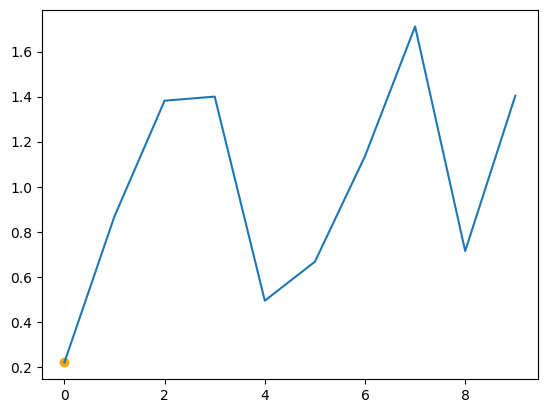

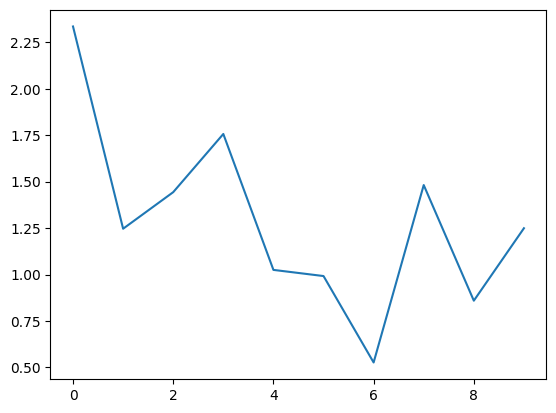

In [8]:
for chpt_idx, chpt_val in chpt_hist:
	plt.scatter(chpt_idx, chpt_val, c='orange')
plt.plot(train_loss)
plt.show()

for chpt_idx, chpt_val in chpt_hist2:
	plt.scatter(chpt_idx, chpt_val, c='orange')
plt.plot(train_loss2)
plt.show()

In [10]:
from models.configs import SYS_TEST_CONFIGS


print(f'Testing LSTM')
for key, item in SYS_TEST_CONFIGS.items():
	print(f'Training "{key}"!')
	model     = lstm_mol.BG_LSTM(item['h_size'], item['l_config']).to(device)
	loss_fn   = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

	trainer = train.ModelTrainer(
		'LSTM_'+key, model, device, test_train_dataloader, loss_fn, optimizer,
		out_dir='saved_models'
	)

	trainer.train(n_epochs=10)
	print(f'\nSecond training')
	trainer.train(n_epochs=10, load_checkpoint=True)
	print()
print(f'Testing GRU')
for key, item in SYS_TEST_CONFIGS.items():
	print(f'Training "{key}"!')
	model     = lstm_mol.BG_GRU(item['h_size'], item['l_config']).to(device)
	loss_fn   = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

	trainer = train.ModelTrainer(
		'GRU_'+key, model, device, test_train_dataloader, loss_fn, optimizer,
		out_dir='saved_models'
	)

	trainer.train(n_epochs=10)
	print(f'\nSecond training')
	trainer.train(n_epochs=10, load_checkpoint=True)
	print()

Testing LSTM
Training "TEST_h5_3x3_ReLU"!


E[1/10] | St Loss(inf): : 10it [00:01,  5.65it/s]
E[2/10] | St Loss(1.25e+00): : 10it [00:02,  3.60it/s]
E[3/10] | St Loss(3.23e-01): : 10it [00:02,  4.27it/s]
E[4/10] | St Loss(1.48e+00): : 10it [00:02,  4.94it/s]
E[5/10] | St Loss(1.21e+00): : 10it [00:02,  4.68it/s]
E[6/10] | St Loss(8.46e-01): : 10it [00:02,  4.77it/s]
E[7/10] | St Loss(1.56e+00): : 10it [00:02,  4.82it/s]
E[8/10] | St Loss(1.35e+00): : 10it [00:01,  5.62it/s]
E[9/10] | St Loss(1.97e-01): : 10it [00:01,  6.02it/s]
E[10/10] | St Loss(3.94e-01): : 10it [00:01,  5.87it/s]


Final train loss: 1.596e+00
Final best loss : 4.942e-01

Second training
Loading previous checkpoint... Done!, resuming from epoch[6]


E[7/16] | St Loss(4.94e-01): : 10it [00:01,  5.47it/s]
E[8/16] | St Loss(9.59e-01): : 10it [00:01,  5.11it/s]
E[9/16] | St Loss(5.82e-01): : 10it [00:01,  5.26it/s]
E[10/16] | St Loss(5.07e-01): : 10it [00:01,  5.67it/s]
E[11/16] | St Loss(2.01e+00): : 10it [00:01,  5.51it/s]
E[12/16] | St Loss(7.38e-01): : 10it [00:01,  5.74it/s]
E[13/16] | St Loss(2.89e-01): : 10it [00:01,  5.58it/s]
E[14/16] | St Loss(1.33e+00): : 10it [00:01,  5.91it/s]
E[15/16] | St Loss(7.46e-01): : 10it [00:01,  5.86it/s]
E[16/16] | St Loss(1.07e+00): : 10it [00:02,  4.76it/s]


Final train loss: 7.789e-01
Final best loss : 2.901e-01

Training "TEST_h10_3i3i1_ReLU"!


E[1/10] | St Loss(inf): : 10it [00:01,  5.46it/s]
E[2/10] | St Loss(7.17e-01): : 10it [00:01,  5.81it/s]
E[3/10] | St Loss(1.70e+00): : 10it [00:01,  5.84it/s]
E[4/10] | St Loss(8.36e-01): : 10it [00:01,  6.10it/s]
E[5/10] | St Loss(9.79e-01): : 10it [00:01,  6.00it/s]
E[6/10] | St Loss(5.53e-01): : 10it [00:01,  5.37it/s]
E[7/10] | St Loss(6.85e-01): : 10it [00:02,  4.59it/s]
E[8/10] | St Loss(8.70e-01): : 10it [00:02,  4.78it/s]
E[9/10] | St Loss(7.16e-01): : 10it [00:01,  5.55it/s]
E[10/10] | St Loss(5.29e-01): : 10it [00:01,  5.65it/s]


Final train loss: 1.300e+00
Final best loss : 3.135e-01

Second training
Loading previous checkpoint... Done!, resuming from epoch[1]


E[2/11] | St Loss(3.14e-01): : 10it [00:01,  5.62it/s]
E[3/11] | St Loss(3.49e-01): : 10it [00:01,  5.70it/s]
E[4/11] | St Loss(7.95e-01): : 10it [00:01,  5.33it/s]
E[5/11] | St Loss(7.64e-01): : 10it [00:01,  5.49it/s]
E[6/11] | St Loss(4.94e-01): : 10it [00:01,  5.38it/s]
E[7/11] | St Loss(5.08e-01): : 10it [00:01,  5.34it/s]
E[8/11] | St Loss(1.63e+00): : 10it [00:01,  5.70it/s]
E[9/11] | St Loss(2.03e+00): : 10it [00:01,  5.76it/s]
E[10/11] | St Loss(9.72e-01): : 10it [00:01,  6.17it/s]
E[11/11] | St Loss(2.08e+00): : 10it [00:01,  6.10it/s]


Final train loss: 5.178e-01
Final best loss : 3.135e-01

Testing GRU
Training "TEST_h5_3x3_ReLU"!


E[1/10] | St Loss(inf): : 10it [00:01,  5.99it/s]
E[2/10] | St Loss(7.67e-01): : 10it [00:01,  5.70it/s]
E[3/10] | St Loss(1.77e+00): : 10it [00:01,  5.89it/s]
E[4/10] | St Loss(1.30e+00): : 10it [00:01,  5.19it/s]
E[5/10] | St Loss(1.08e+00): : 10it [00:01,  5.12it/s]
E[6/10] | St Loss(4.43e-01): : 10it [00:02,  4.99it/s]
E[7/10] | St Loss(8.21e-01): : 10it [00:01,  5.19it/s]
E[8/10] | St Loss(6.10e-01): : 10it [00:01,  5.52it/s]
E[9/10] | St Loss(4.80e-01): : 10it [00:01,  5.20it/s]
E[10/10] | St Loss(1.04e+00): : 10it [00:01,  5.48it/s]


Final train loss: 1.177e+00
Final best loss : 4.142e-01

Second training
Loading previous checkpoint... Done!, resuming from epoch[2]


E[3/12] | St Loss(4.14e-01): : 10it [00:02,  4.91it/s]
E[4/12] | St Loss(8.59e-01): : 10it [00:02,  4.32it/s]
E[5/12] | St Loss(9.36e-01): : 10it [00:01,  5.44it/s]
E[6/12] | St Loss(9.57e-01): : 10it [00:02,  4.67it/s]
E[7/12] | St Loss(8.65e-01): : 10it [00:01,  5.51it/s]
E[8/12] | St Loss(1.63e+00): : 10it [00:01,  5.42it/s]
E[9/12] | St Loss(5.22e-01): : 10it [00:02,  4.77it/s]
E[10/12] | St Loss(1.65e+00): : 10it [00:02,  4.36it/s]
E[11/12] | St Loss(5.70e-01): : 10it [00:02,  4.51it/s]
E[12/12] | St Loss(2.10e+00): : 10it [00:01,  5.16it/s]


Final train loss: 1.274e+00
Final best loss : 4.142e-01

Training "TEST_h10_3i3i1_ReLU"!


E[1/10] | St Loss(inf): : 10it [00:01,  5.71it/s]
E[2/10] | St Loss(1.55e+00): : 10it [00:01,  5.50it/s]
E[3/10] | St Loss(9.61e-01): : 10it [00:01,  5.84it/s]
E[4/10] | St Loss(6.08e-01): : 10it [00:01,  6.13it/s]
E[5/10] | St Loss(9.31e-01): : 10it [00:01,  6.25it/s]
E[6/10] | St Loss(7.37e-01): : 10it [00:01,  5.47it/s]
E[7/10] | St Loss(4.06e-01): : 10it [00:01,  5.29it/s]
E[8/10] | St Loss(8.19e-01): : 10it [00:01,  6.01it/s]
E[9/10] | St Loss(7.01e-01): : 10it [00:01,  5.77it/s]
E[10/10] | St Loss(2.28e+00): : 10it [00:01,  6.04it/s]


Final train loss: 8.855e-01
Final best loss : 7.015e-01

Second training
Loading previous checkpoint... Done!, resuming from epoch[2]


E[3/12] | St Loss(7.01e-01): : 10it [00:01,  6.20it/s]
E[4/12] | St Loss(1.04e+00): : 10it [00:01,  5.94it/s]
E[5/12] | St Loss(2.16e+00): : 10it [00:01,  6.66it/s]
E[6/12] | St Loss(4.39e-01): : 10it [00:01,  5.50it/s]
E[7/12] | St Loss(1.59e+00): : 10it [00:01,  5.19it/s]
E[8/12] | St Loss(5.60e-01): : 10it [00:01,  5.75it/s]
E[9/12] | St Loss(4.88e-01): : 10it [00:01,  5.86it/s]
E[10/12] | St Loss(6.42e-01): : 10it [00:01,  5.93it/s]
E[11/12] | St Loss(3.35e-01): : 10it [00:01,  6.14it/s]
E[12/12] | St Loss(1.84e+00): : 10it [00:01,  5.12it/s]

Final train loss: 4.754e-01
Final best loss : 5.620e-01

